# Project 2: GANs
#### Malachi Eberly

In [31]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T

import torch.nn.functional as F

import torch.optim as optim

import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import numpy as np

### 1. Dataset Preperation

100%|██████████| 26421880/26421880 [00:04<00:00, 6103089.31it/s]


Extracting .\FashionMNIST\raw\train-images-idx3-ubyte.gz to .\FashionMNIST\raw



100%|██████████| 29515/29515 [00:00<00:00, 342166.69it/s]


Extracting .\FashionMNIST\raw\train-labels-idx1-ubyte.gz to .\FashionMNIST\raw



100%|██████████| 4422102/4422102 [00:01<00:00, 4251771.78it/s]


Extracting .\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to .\FashionMNIST\raw



100%|██████████| 5148/5148 [00:00<?, ?it/s]

Extracting .\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to .\FashionMNIST\raw



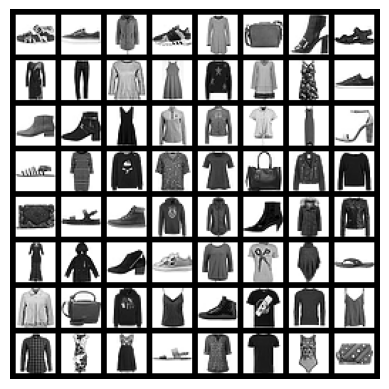

In [32]:
torch.manual_seed(42)
transform = T.Compose([
    T.ToTensor(),
    T.Normalize([0.5], [0.5])]
)

batch_size = 64

trainset = torchvision.datasets.FashionMNIST(
    root=".", train=True, download=True, transform=transform
)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, shuffle=True
)

images, labels = next(iter(trainloader))
grid = make_grid(0.5-images/2, 8, 4)
plt.imshow(grid.numpy().transpose((1, 2, 0)),
           cmap = "gray_r")
plt.axis("off")
plt.show()

### 2. GAN Architecture

In [38]:
class Generator(nn.Module):
    
    def __init__(self):
        super(Generator, self).__init__()
        self.z_dim = 100
        self.model = nn.Sequential(
            nn.Linear(self.z_dim, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 784),
            nn.Tanh()
        )
    
    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), 784)
        return img

class Discriminator(nn.Module):
    
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.model = nn.Sequential(
                nn.Linear(784, 1024),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.3),
                nn.Linear(1024, 512),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.3),
                nn.Linear(512, 256),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.3),
                nn.Linear(256, 128),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout(0.3),
                nn.Linear(128, 1),
                nn.Sigmoid()
        )
    
    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)
        return validity

device = "cuda" if torch.cuda.is_available() else "cpu"
generator = Generator().to(device)
discriminator = Discriminator().to(device)

### 3. Loss and Optimizer

In [39]:
criterion = nn.BCELoss()

g_optimizer = optim.Adam(generator.parameters(), lr=1e-4)
d_optimizer = optim.Adam(discriminator.parameters(), lr=1e-4)

### 4. Training Loop

Epoch [1/2], Step [100/938], d_loss: 0.4998, g_loss: 2.5866
Epoch [1/2], Step [200/938], d_loss: 0.5012, g_loss: 3.4021
Epoch [1/2], Step [300/938], d_loss: 0.3096, g_loss: 3.1568
Epoch [1/2], Step [400/938], d_loss: 0.4946, g_loss: 2.3233
Epoch [1/2], Step [500/938], d_loss: 0.5835, g_loss: 2.2445
Epoch [1/2], Step [600/938], d_loss: 0.2230, g_loss: 3.0467
Epoch [1/2], Step [700/938], d_loss: 0.3677, g_loss: 2.6426
Epoch [1/2], Step [800/938], d_loss: 0.6946, g_loss: 2.7998
Epoch [1/2], Step [900/938], d_loss: 0.5208, g_loss: 2.7274


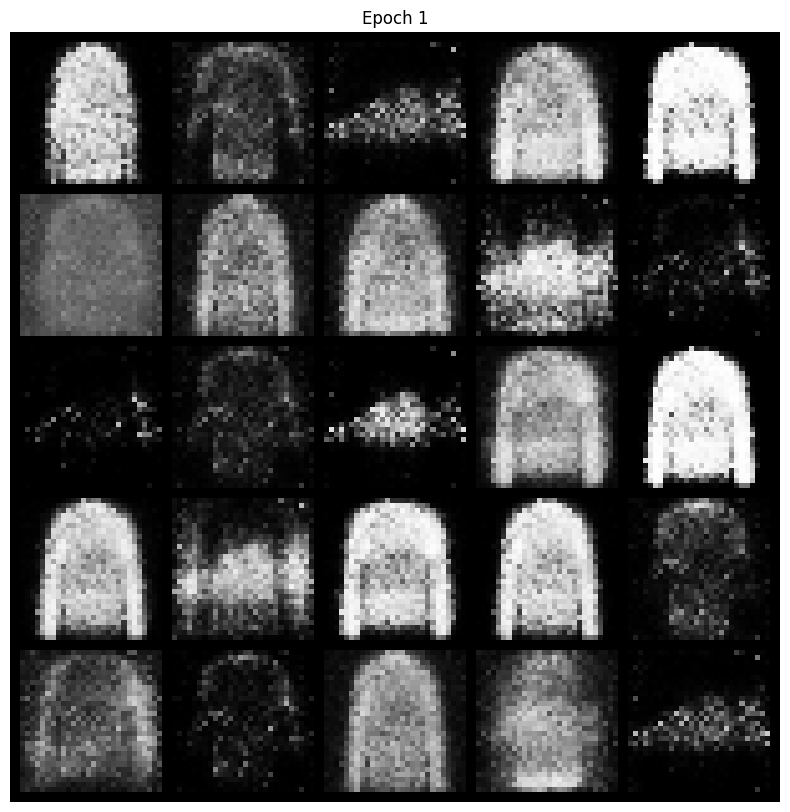

Epoch [2/2], Step [100/938], d_loss: 0.6484, g_loss: 2.5935
Epoch [2/2], Step [200/938], d_loss: 0.4158, g_loss: 2.8926
Epoch [2/2], Step [300/938], d_loss: 0.8891, g_loss: 2.8238
Epoch [2/2], Step [400/938], d_loss: 0.4998, g_loss: 2.2258
Epoch [2/2], Step [500/938], d_loss: 0.7572, g_loss: 2.1492
Epoch [2/2], Step [600/938], d_loss: 0.8620, g_loss: 2.5532
Epoch [2/2], Step [700/938], d_loss: 0.6605, g_loss: 2.3655
Epoch [2/2], Step [800/938], d_loss: 0.5792, g_loss: 2.1355
Epoch [2/2], Step [900/938], d_loss: 0.8321, g_loss: 2.6150


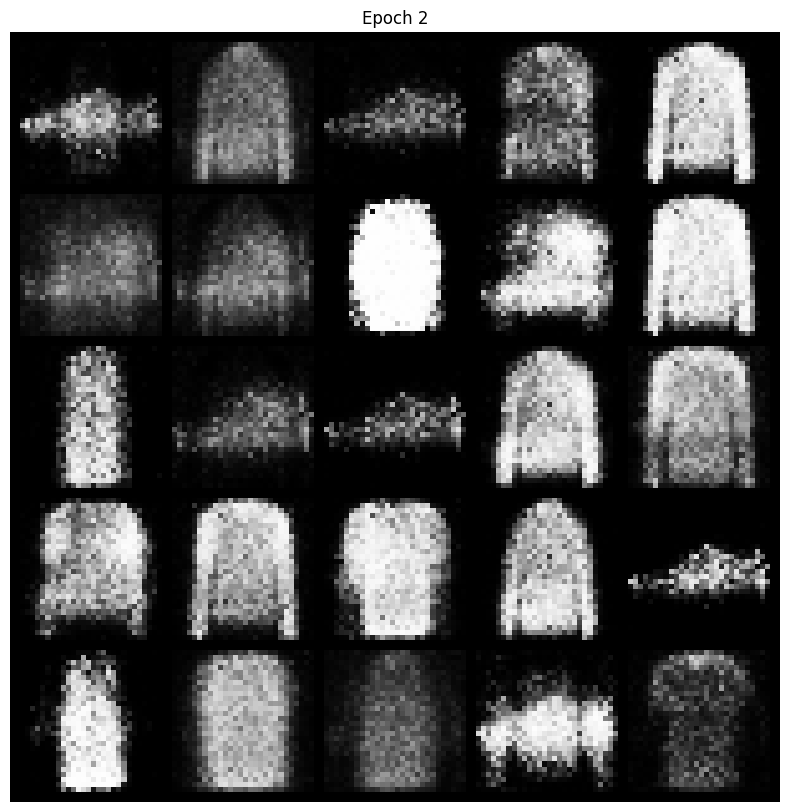

Training finished


In [45]:
def show_generated_images(images, num_images=25, title='Generated Images'):
    plt.figure(figsize=(10, 10))
    images = images / 2 + 0.5
    images = images.clamp(0, 1)
    image_grid = make_grid(images[:num_images], nrow=5, normalize=False).cpu().numpy()
    plt.imshow(np.transpose(image_grid, (1, 2, 0)), interpolation='nearest')
    plt.title(title)
    plt.axis('off')
    plt.show()

g_loss_curve = []
d_loss_curve = []

num_epochs = 50
for epoch in range(num_epochs):
    for i, (real_images, _) in enumerate(trainloader):
        current_batch_size = real_images.size(0)
        real_images = real_images.to(device)
        
        real_labels = torch.ones(current_batch_size, 1).to(device)
        fake_labels = torch.zeros(current_batch_size, 1).to(device)
        
        d_optimizer.zero_grad()
        
        real_outputs = discriminator(real_images)
        d_loss_real = criterion(real_outputs, real_labels)
        
        z = torch.randn(current_batch_size, 100).to(device)
        fake_images = generator(z)
        fake_outputs = discriminator(fake_images.detach())
        d_loss_fake = criterion(fake_outputs, fake_labels)
        
        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        d_optimizer.step()
        
        g_optimizer.zero_grad()
        
        fake_outputs = discriminator(fake_images)
        g_loss = criterion(fake_outputs, real_labels)
        
        g_loss.backward()
        g_optimizer.step()
        
        g_loss_curve.append(g_loss.item())
        d_loss_curve.append(d_loss.item())
        
        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(trainloader)}], d_loss: {d_loss.item():.4f}, g_loss: {g_loss.item():.4f}')
        if i+1 == len(trainloader):
                show_generated_images(fake_images.view(-1, 1, 28, 28), title=f'Epoch {epoch+1}')
            
print("Training finished")

### 5. Visualization

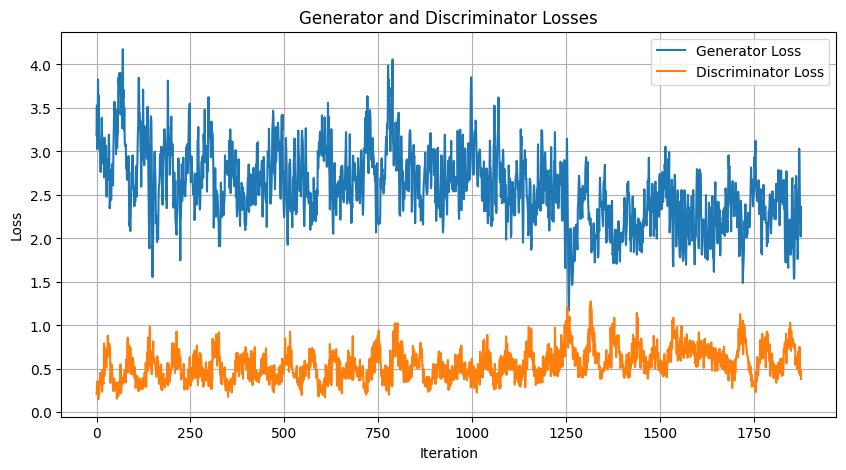

In [46]:
plt.figure(figsize=(10, 5))
plt.plot(g_loss_curve, label = "Generator Loss")
plt.plot(d_loss_curve, label = "Discriminator Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Generator and Discriminator Losses")
plt.legend()
plt.grid(True)
plt.show()